In [1]:
# Example from:
# https://fluxml.ai/Flux.jl/stable/models/quickstart/

using Flux, Statistics, ProgressMeter

In [2]:
# Generate some data for the XOR problem: vectors of length 2, as columns of a matrix:
noisy = rand(Float32, 2, 1000)                                    # 2×1000 Matrix{Float32}
truth = [xor(col[1]>0.5, col[2]>0.5) for col in eachcol(noisy)];   # 1000-element Vector{Bool}

1000-element Vector{Bool}:
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 1
 1
 1
 1
 1
 0

In [3]:
# Define our model, a multi-layer perceptron with one hidden layer of size 3:
model = Chain(
    Dense(2 => 3, tanh),   # activation function inside layer
    BatchNorm(3),
    Dense(3 => 2),
    softmax) |> gpu        # move model to GPU, if available


┌ Info: The GPU function is being called but the GPU is not accessible. 
│ Defaulting back to the CPU. (No action is required if you want to run on the CPU).
└ @ Flux /Users/james/.julia/packages/Flux/kq9Et/src/functor.jl:201


Chain(
  Dense(2 => 3, tanh),                  # 9 parameters
  BatchNorm(3),                         # 6 parameters, plus 6
  Dense(3 => 2),                        # 8 parameters
  NNlib.softmax,
)         # Total: 6 trainable arrays, 23 parameters,
          # plus 2 non-trainable, 6 parameters, summarysize 604 bytes.

In [4]:
# The model encapsulates parameters, randomly initialised. Its initial output is:
out1 = model(noisy |> gpu) |> cpu                                 # 2×1000 Matrix{Float32}

2×1000 Matrix{Float32}:
 0.477741  0.366701  0.345281  0.286982  …  0.369678  0.439516  0.361846
 0.522259  0.633299  0.654719  0.713018     0.630322  0.560484  0.638154

In [5]:
# To train the model, we use batches of 64 samples, and one-hot encoding:
target = Flux.onehotbatch(truth, [true, false])                   # 2×1000 OneHotMatrix
loader = Flux.DataLoader((noisy, target) |> gpu, batchsize=64, shuffle=true);
# 16-element DataLoader with first element: (2×64 Matrix{Float32}, 2×64 OneHotMatrix)

16-element DataLoader(::Tuple{Matrix{Float32}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, shuffle=true, batchsize=64)
  with first element:
  (2×64 Matrix{Float32}, 2×64 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

In [6]:
optim = Flux.setup(Flux.Adam(0.01), model)  # will store optimiser momentum, etc.

(layers = ((weight = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0; 0.0 0.0; 0.0 0.0], Float32[0.0 0.0; 0.0 0.0; 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0], (0.9, 0.999))), σ = ()), (λ = (), β = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0], (0.9, 0.999))), γ = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0], (0.9, 0.999))), μ = (), σ² = (), ϵ = (), momentum = (), affine = (), track_stats = (), active = (), chs = ()), (weight = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 0.0; 0.0 0.0 0.0], Float32[0.0 0.0 0.0; 0.0 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0], Float32[0.0, 0.0], (0.9, 0.999))), σ = ()), ()),)

In [7]:
# Training loop, using the whole data set 1000 times:
losses = []
# @showprogress (not so useful in notebook)
for epoch in 1:1_000
    for (x, y) in loader
        # The do block creates an anonymous function, as the first argument of gradient. Anything executed within this is differentiated.
        loss, grads = Flux.withgradient(model) do m
            # Evaluate model and loss inside gradient context:
            y_hat = m(x)
            Flux.crossentropy(y_hat, y)
        end
        Flux.update!(optim, model, grads[1])
        push!(losses, loss)  # logging, outside gradient context
    end
end

In [8]:
optim # parameters, momenta and output have all changed

(layers = ((weight = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[-0.0142248 -0.000267997; -0.00601866 -0.00853969; 0.0236553 -0.0400985], Float32[0.00755106 0.0122251; 0.00722889 0.0143706; 0.196066 0.0828093], (2.5e-323, 1.11526e-7))), bias = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[-0.0210802, -0.00872996, -0.00789056], Float32[0.02485, 0.029267, 0.0434274], (2.5e-323, 1.11526e-7))), σ = ()), (λ = (), β = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0244884, 0.0209093, 0.0310294], Float32[0.0387879, 0.0284219, 0.0623569], (2.5e-323, 1.11526e-7))), γ = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[-0.00453024, 0.0100839, -0.0105273], Float32[0.0158814, 0.0121709, 0.0130537], (2.5e-323, 1.11526e-7))), μ = (), σ² = (), ϵ = (), momentum = (), affine = (), track_stats = (), active = (), chs = ()), (weight = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.00206691 -0.0100855 0.00485737; -0.00206691 0.0100855 -0.00485737], Flo

In [9]:
out2 = model(noisy |> gpu) |> cpu  # first row is prob. of true, second row p(false)

2×1000 Matrix{Float32}:
 0.967488   0.50818  0.119585  4.65196f-5  …  0.876216  0.999891     0.250151
 0.0325124  0.49182  0.880415  0.999954       0.123784  0.000108783  0.749849

In [10]:
mean((out2[1,:] .> 0.5) .== truth)  # accuracy > 94% so far!

0.966

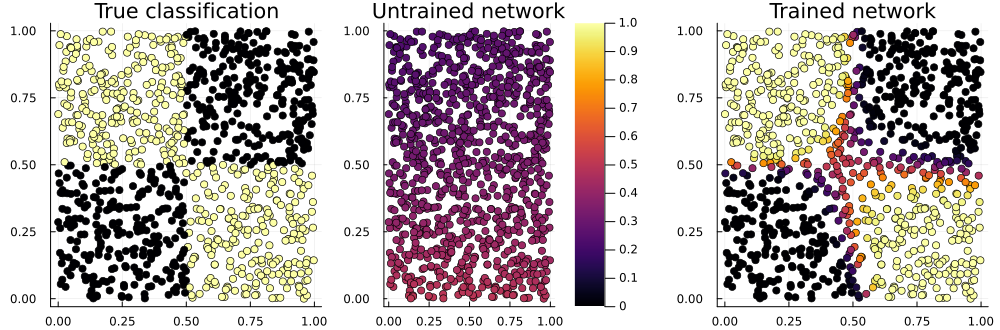

In [11]:
using Plots  # to draw the above figure

p_true = scatter(noisy[1,:], noisy[2,:], zcolor=truth, title="True classification", legend=false)
p_raw =  scatter(noisy[1,:], noisy[2,:], zcolor=out1[1,:], title="Untrained network", label="", clims=(0,1))
p_done = scatter(noisy[1,:], noisy[2,:], zcolor=out2[1,:], title="Trained network", legend=false)

plot(p_true, p_raw, p_done, layout=(1,3), size=(1000,330))

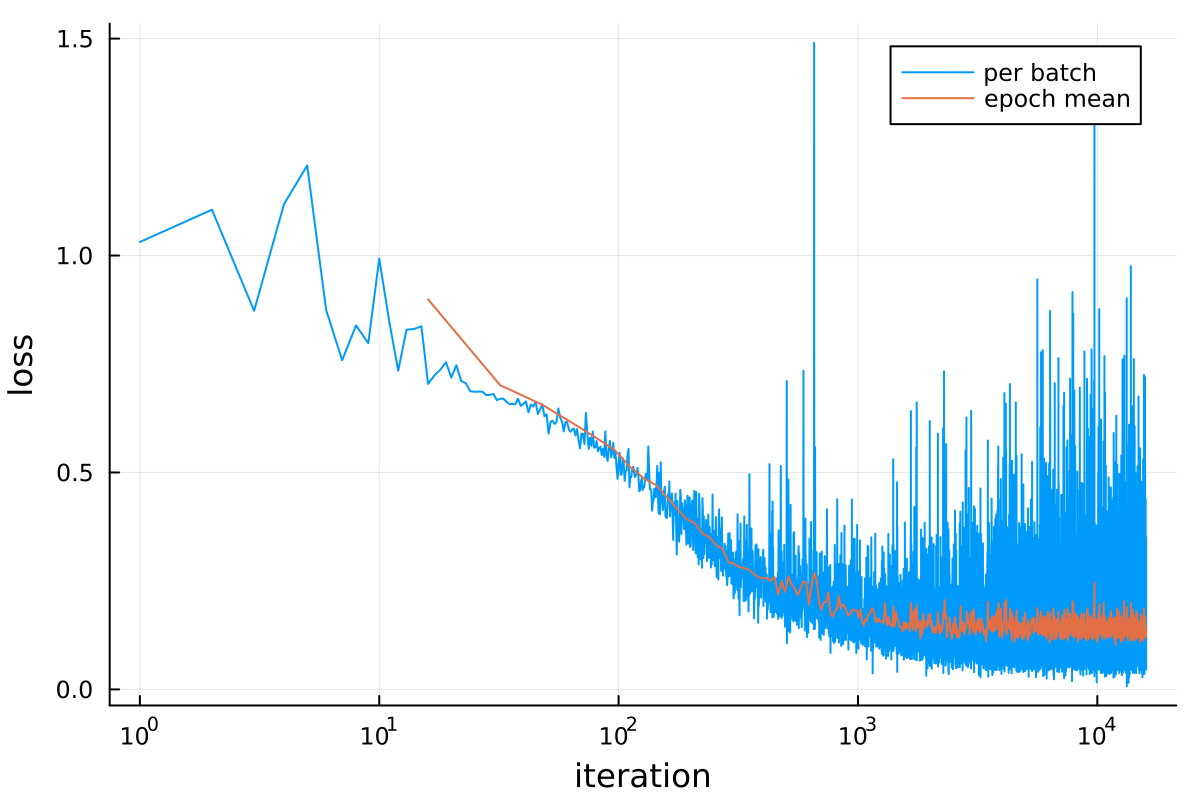

In [12]:
# Plot losses during training: 
plot(losses; xaxis=(:log10, "iteration"),yaxis="loss", label="per batch")
n = length(loader)
plot!(n:n:length(losses), mean.(Iterators.partition(losses, n)),label="epoch mean", dpi=200)